In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

import sklearn as sk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ntaba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ntaba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ntaba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
dataset = pd.read_csv("data.csv",encoding= 'unicode_escape')

In [3]:
dataset.head()

,Comments,Text Label
0,yeah I got 2 backups for all that. I just hate...,NonBullying
1,I hate using my BB but love my iPhone. Haven'...,NonBullying
2,Get fucking real dude.,Bullying
3,She is as dirty as they come and that crook ...,Bullying
4,why did you fuck it up. I could do it all day...,Bullying


In [4]:
dataset.shape

(15664, 2)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15664 entries, 0 to 15663
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Comments    15664 non-null  object
 1   Text Label  15664 non-null  object
dtypes: object(2)
memory usage: 244.9+ KB


In [6]:
dataset.isnull()

,Comments,Text Label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
15659,False,False
15660,False,False
15661,False,False
15662,False,False


In [7]:
### Number Of Categories
dataset['Text Label'].value_counts()

NonBullying    9846
Bullying       5818
Name: Text Label, dtype: int64

In [8]:
dataset['CategoryId'] = dataset['Text Label'].factorize()[0]
dataset.head(200)

,Comments,Text Label,CategoryId
0,yeah I got 2 backups for all that. I just hate...,NonBullying,0
1,I hate using my BB but love my iPhone. Haven'...,NonBullying,0
2,Get fucking real dude.,Bullying,1
3,She is as dirty as they come and that crook ...,Bullying,1
4,why did you fuck it up. I could do it all day...,Bullying,1
...,...,...,...
195,told ya she was fat! she's loyal tho she has ...,Bullying,1
196,if you tweet about that damn song one more tim...,Bullying,1
197,I have all th nerd at home and I'm a smart ass...,Bullying,1
198,u got me lemming for some laneige whitening sh...,Bullying,1


In [9]:
dataset.describe()

,CategoryId
count,15664.000000
mean,0.371425
std,0.483201
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
# Create a new pandas dataframe "category", which only has unique Categories, also sorting this list in order of CategoryId values
category = dataset[['Text Label', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

,Text Label,CategoryId
0,NonBullying,0
2,Bullying,1


In [11]:
category_to_id = dict(category.values)
id_to_category = dict(category[['CategoryId', 'Text Label']].values)
id_to_category

{0: 'NonBullying', 1: 'Bullying'}

<AxesSubplot:xlabel='Text Label'>

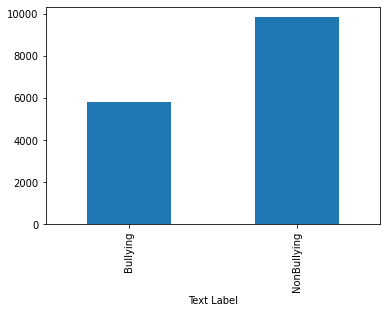

In [12]:
dataset.groupby('Text Label').CategoryId.count().plot.bar(ylim = 0)

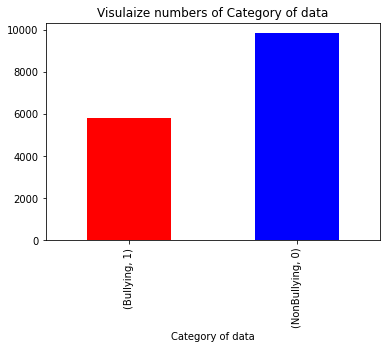

In [13]:
dataset.groupby('Text Label').CategoryId.value_counts().plot(kind = "bar", color = [ "red", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

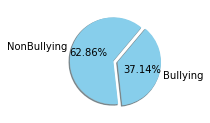

In [14]:
fig = plt.figure(figsize = (2,2,))
colors = ["skyblue"]
Bullying = dataset[dataset['CategoryId']==0]
NonBullying = dataset[dataset['CategoryId']==1]
count = [Bullying['CategoryId'].count(), NonBullying['CategoryId'].count()]
pie = plt.pie(count, labels = ['NonBullying','Bullying' ],
              autopct = "%1.2f%%",
              shadow = True,
              colors = colors,
              startangle = 50,
              explode = ( 0.05,0.05))

In [15]:
text = dataset["Comments"]
text.head(10)

0    yeah I got 2 backups for all that. I just hate...
1    I hate using my BB  but love my iPhone. Haven'...
2                               Get fucking real dude.
3     She is as dirty as they come  and that crook ...
4     why did you fuck it up. I could do it all day...
5     Dude they dont finish enclosing the fucking s...
6     WTF are you talking about Men? No men thats n...
7    Ill save you the trouble sister. Here comes a ...
8     Im dead serious.Real athletes never cheat don...
9        wow lol sounds like a lot of piss then hehehe
Name: Comments, dtype: object

In [16]:
category = dataset['Text Label']
category.head(5)

0    NonBullying
1    NonBullying
2       Bullying
3       Bullying
4       Bullying
Name: Text Label, dtype: object

# DATA PREPROCESSING

In [17]:
def remove_tags(text):
  remove = re.compile(r'<.*?>')
  return re.sub(remove, '', text)

dataset['Comments'] = dataset['Comments'].apply(remove_tags)
dataset['Comments'][1]

"I hate using my BB  but love my iPhone. Haven't tried the new BB. My BB is provided by my corp. I don't get to pick which model"

In [18]:
def special_char(text):
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews

dataset['Comments'] = dataset['Comments'].apply(special_char)
dataset['Comments'][1]

'I hate using my BB  but love my iPhone  Haven t tried the new BB  My BB is provided by my corp  I don t get to pick which model'

In [19]:
def convert_lower(text):
   return text.lower()

dataset['Comments'] = dataset['Comments'].apply(convert_lower)
dataset['Comments'][1]

'i hate using my bb  but love my iphone  haven t tried the new bb  my bb is provided by my corp  i don t get to pick which model'

In [20]:
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  return [x for x in words if x not in stop_words]

dataset['Comments'] = dataset['Comments'].apply(remove_stopwords)
dataset['Comments'][100]

['grown',
 'man',
 'include',
 'dip',
 'sentence',
 'lol',
 'know',
 'hatin',
 'fuck',
 'lookin',
 'snow',
 'lol']

In [21]:
def lemmatize_word(text):
  wordnet = WordNetLemmatizer()
  return " ".join([wordnet.lemmatize(word) for word in text])

dataset['Comments'] = dataset['Comments'].apply(lemmatize_word)
dataset['Comments'][1]

'hate using bb love iphone tried new bb bb provided corp get pick model'

In [22]:
dataset

,Comments,Text Label,CategoryId
0,yeah got 2 backup hate happen strugglin week h...,NonBullying,0
1,hate using bb love iphone tried new bb bb prov...,NonBullying,0
2,get fucking real dude,Bullying,1
3,dirty come crook rengel dems fucking corrupt j...,Bullying,1
4,fuck could day let hour ping later sched writi...,Bullying,1
...,...,...,...
15659,yutz,Bullying,1
15660,zebrafucker,Bullying,1
15661,zitface,Bullying,1
15662,zoophile,Bullying,1


Bullying related words:


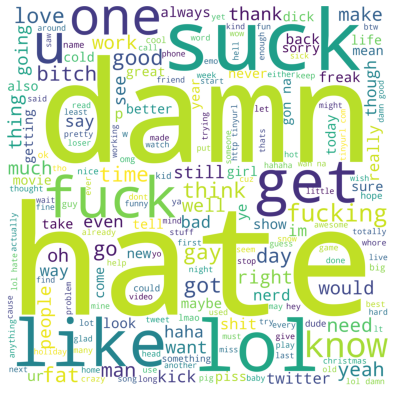

NonBullying related words:


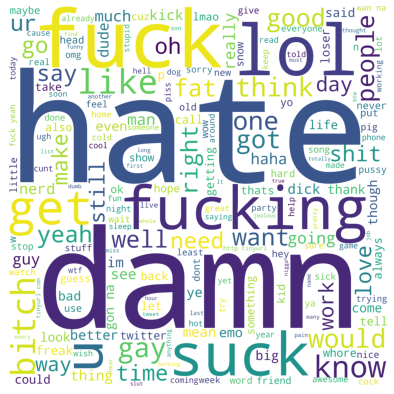

In [23]:
from wordcloud import WordCloud
stop = set(stopwords.words('english'))

Bullying = dataset[dataset['CategoryId'] == 0]
Bullying = Bullying['Comments']

NonBullying = dataset[dataset['CategoryId'] == 1]
NonBullying = NonBullying['Comments']


def wordcloud_draw(dataset, color = 'white'):
  words = ' '.join(dataset)
  cleaned_word = ' '.join([word for word in words.split()
                           if (word != 'news' and word != 'text')])
  wordcloud = WordCloud(stopwords = stop,
                        background_color = color,
                        width = 2500, height = 2500).generate(cleaned_word)

  plt.figure(1, figsize = (10,7))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

print("Bullying related words:")
wordcloud_draw(Bullying, 'white')

print("NonBullying related words:")
wordcloud_draw(NonBullying, 'white')

# TEXT VECTORIZATION

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.CategoryId.values)

cv = CountVectorizer(max_features = 2000)
x = cv.fit_transform(dataset.Comments).toarray()

print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (15664, 2000)
y.shape =  (15664,)


In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, shuffle = True)


print(len(x_train))
print(len(x_test))

12531
3133


# model training

In [26]:
classifier=RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=0).fit(x_train, y_train)


# performance evaluations

In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, x_train, y_train,cv=10 ,scoring='accuracy' )
print(scores)

[0.84051037 0.83878691 0.83719074 0.84038308 0.83479649 0.85395052
 0.84038308 0.83878691 0.85155626 0.84676776]


In [28]:
#calculate mean
print ('Mean of K-folds ' ,scores.mean())

Mean of K-folds  0.8423112122612271


In [29]:
y_pred=classifier.predict(x_test)
sk.metrics.accuracy_score(y_test,y_pred)

0.8704117459304181

In [30]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test,y_pred)
print(cf_matrix)

[[1787  156]
 [ 250  940]]


<AxesSubplot:>

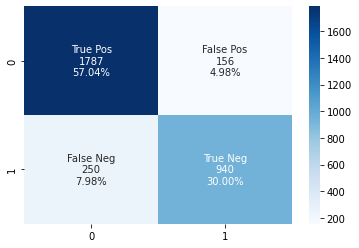

In [31]:
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [32]:
sk.metrics.accuracy_score(y_test,y_pred)

0.8704117459304181

In [33]:
sk.metrics.precision_score(y_test, y_pred)

0.8576642335766423

In [34]:
sk.metrics.recall_score(y_test, y_pred)

0.7899159663865546

In [35]:
sk.metrics.f1_score(y_test, y_pred)

0.8223972003499562

In [36]:
y_pred1 = cv.transform(['i love you'])
yy = classifier.predict(y_pred1)
result = ""
if yy == [0]:
  result = "This is NonBullying sentence"
elif yy == [1]:
  result = "This is Bullying sentence"
print(result)

This is NonBullying sentence
